In [ ]:
import random
N_number = 17316878
random.seed(N_number)

import numpy as np

import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


!pip uninstall umap
!pip install umap-learn
# umap-learn library is designed to be similar to scikit-learn
from umap import UMAP

from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

from google.colab import files
import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=3d678222264aa14523a8a1a105eaee9b699e808285e8dffee5be0063a67589a3
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=99dcf474a65c56e6f6a118929a741ed4960d34b9acda538e8c715ad0701cd1c8
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
uploaded = files.upload()

Saving musicData.csv to musicData.csv


In [ ]:
file = pd.read_csv(io.BytesIO(uploaded["musicData.csv"]))
file.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


#**Data Cleaning**

In [ ]:
# 5000 songs per genre
file["music_genre"].value_counts()

Electronic     5000
Anime          5000
Jazz           5000
Alternative    5000
Country        5000
Rap            5000
Blues          5000
Rock           5000
Classical      5000
Hip-Hop        5000
Name: music_genre, dtype: int64

In [ ]:
# each column contains 5 nulls
file.isna().sum(axis = 0)

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64

In [ ]:
# Will need to drop the 5 null rows from the file that have a missing music_genre value, since that is our required label
file = file[file['music_genre'].notna()]

# The even distribution of counts is nice
file["music_genre"].value_counts()

Electronic     5000
Anime          5000
Jazz           5000
Alternative    5000
Country        5000
Rap            5000
Blues          5000
Rock           5000
Classical      5000
Hip-Hop        5000
Name: music_genre, dtype: int64

In [ ]:
# interestingly, that solved all the null values for the entire dataset
file.isna().sum(axis = 0)

instance_id         0
artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

In [ ]:
# now, we need to check for unusual values for the rest of the columns, such as "?" in the tempo column

# all rows in instance_id and popularity should be integers ... great, they are.
print((file["instance_id"] % 1  == 0).all())
print((file["popularity"] % 1  == 0).all())

# in addition, popularity is in between 0 and 100
print(file["popularity"].between(0,100).all())

# and instance_id should be unique - great, it is
print(file["instance_id"].is_unique)

True
True
True
True


In [ ]:
# artist_name should only contain some sort of name, not "!!!" in some places; track_name doesn't have this problem
# some symbols aren't ASCII in these columns, but that's ok for the algorithm.

# I decided that I won't drop these rows, since I am not using track_name or artist_name as predictors
#file = file[file.artist_name != "!!!"]

In [ ]:
# acousticness, danceability, energy, instrumentalness, liveness, speechiness, valence should all be real numbers between 0 and 1


# they all are, great.

print(file["acousticness"].notna().all() and is_numeric_dtype(file["acousticness"]) and file["acousticness"].between(0,1).all())
print(file["danceability"].notna().all() and is_numeric_dtype(file["danceability"]) and file["danceability"].between(0,1).all())
print(file["energy"].notna().all() and is_numeric_dtype(file["energy"]) and file["energy"].between(0,1).all())
print(file["instrumentalness"].notna().all() and is_numeric_dtype(file["instrumentalness"]) and file["instrumentalness"].between(0,1).all())
print(file["liveness"].notna().all() and is_numeric_dtype(file["liveness"]) and file["liveness"].between(0,1).all())
print(file["speechiness"].notna().all() and is_numeric_dtype(file["speechiness"]) and file["speechiness"].between(0,1).all())
print(file["valence"].notna().all() and is_numeric_dtype(file["valence"]) and file["valence"].between(0,1).all())

True
True
True
True
True
True
True


In [ ]:
# Duration should be a positive number

# Unfortunately, there are 4939/50000 negative durations. I won't drop these, since that is a lot of data to drop.
# Dropping them won't be good since the other columns that aren't null in these rows will be deleted.
file['duration_ms'].lt(0).sum()

4939

In [ ]:
# As we can see, there is about 4,500 of <=0 millisecond duration values per genre.
# I will most likely replace each negative duration by the mean or median duration by genre -
# first let's see if the genres have substantial differences in duration.

duration_pos_neg = pd.DataFrame(file.groupby('music_genre').duration_ms.apply(lambda x: pd.Series([(x <= 0).sum(), (x > 0).sum()])).unstack())
duration_pos_neg.rename(columns={0: "Negatives", 1: "Positives"}, inplace = True)
duration_pos_neg = duration_pos_neg.style.set_caption("Figure 1: Duration Counts")
duration_pos_neg

,Negatives,Positives
music_genre,,
Alternative,491,4509
Anime,473,4527
Blues,483,4517
Classical,511,4489
Country,492,4508
Electronic,483,4517
Hip-Hop,490,4510
Jazz,497,4503
Rap,512,4488


In [ ]:
# copy the file in order to edit it
copied_file = file.copy(deep = True)

# drop the negatives in duration column
copied_file = copied_file[copied_file.duration_ms > 0]

# there are substantial differences in times
copied_file.groupby('music_genre').duration_ms.apply(lambda x: pd.Series([x.mean()])).unstack()

,0
music_genre,
Alternative,233316.595697
Anime,230705.681025
Blues,253820.226699
Classical,309661.894186
Country,216899.031721
Electronic,270703.431260
Hip-Hop,219951.268071
Jazz,264371.026205
Rap,218927.021390


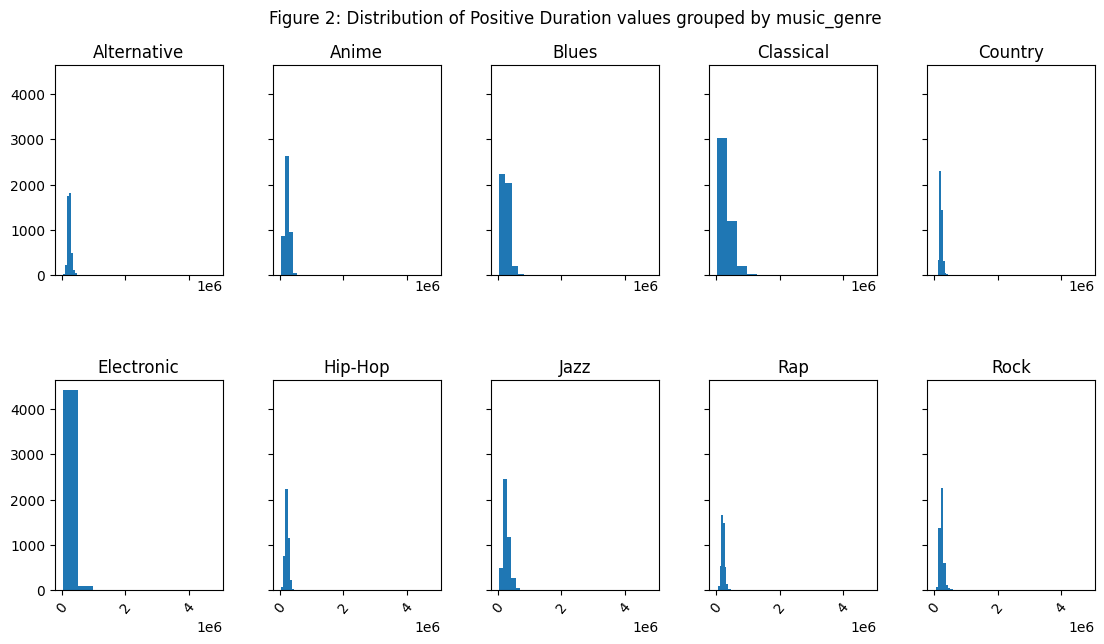

In [ ]:
# The distributions vary quite a bit, from being quite Normal in rap and alternative music, to Exponential in electronic music.
# It's best to replace negative duration values by genre using each genre's median.
copied_file['duration_ms'].hist(by=copied_file['music_genre'], layout = (2,5), sharey=True, sharex = True, xrot = 50, figsize = (13,7))
plt.suptitle("Figure 2: Distribution of Positive Duration values grouped by music_genre")
plt.show()

In [ ]:
# replace each genre's negative duration values with that genre's median duration time

# replace negatives with NaN first
file['duration_ms'] = file['duration_ms'].map(lambda x: np.nan if x <= 0 else x)

# now replace NaN with median duration time, by group
file['duration_ms'] = file.groupby("music_genre").duration_ms.transform(lambda x: x.fillna(x.median()))

In [ ]:
# Ok, duration_ms column has been fixed up
print(file['duration_ms'].lt(0).sum())
print(file['duration_ms'].isna().sum())

0
0


In [ ]:
# KEYS - look good
print(file['key'].isna().sum())
print()
file["key"].value_counts()

0



G     5727
C     5522
C#    5405
D     5265
A     4825
F     4341
B     3789
E     3760
A#    3356
G#    3319
F#    3101
D#    1590
Name: key, dtype: int64

In [ ]:
# Loudness is measured as dB = 20log(p/pr)
# The reason why many of the loudness values are negative in the dataset is because pr (reference sound) was higher than p (measured sound).

# Great, no NaN and all numeric.
print(file["loudness"].notna().all() and is_numeric_dtype(file["loudness"]))

True


In [ ]:
# Mode - great, no NaN and no funky values.

print(file["mode"].notna().all())
print()
file["mode"].value_counts()

True



Major    32099
Minor    17901
Name: mode, dtype: int64

In [ ]:
# Tempo

print(file["tempo"].notna().all())
# need to display the non-numeric values
print(is_numeric_dtype(file["tempo"]))
print()

# create an array of booleans indicating numeric or not
is_non_numeric = pd.to_numeric(file['tempo'], errors='coerce').isnull()
# find all the unique non-numeric values, which happen to be "?"
print(file[is_non_numeric]['tempo'].unique())
print()

# There are 4980 "?" in the tempo column. That's many rows to drop which contain information in the other columns, so I'll impute instead.
print(file["tempo"].value_counts()["?"])

True
False

['?']

4980


In [ ]:
# As we can see, there is about the same number of "?" values per genre.
# I will most likely replace each "?" by the mean or median tempo by genre -
# first let's see if the genres have substantial differences in tempo.

question_mark_counts = pd.DataFrame(file.groupby('music_genre').tempo.apply(lambda x: pd.Series([(x == "?").sum()])).unstack())
question_mark_counts.rename(columns={0: "Count"}, inplace = True)
question_mark_counts = question_mark_counts.style.set_caption("Figure 3: Question Mark Counts by Genre")
question_mark_counts

,Count
music_genre,
Alternative,505
Anime,503
Blues,530
Classical,500
Country,514
Electronic,534
Hip-Hop,480
Jazz,479
Rap,496


In [ ]:
# Use the copied file
copied_file = file.copy(deep = True)

# drop the "?" in tempo column
copied_file = copied_file[copied_file.tempo != "?"]


# converting column to numeric and rounding
copied_file['tempo'] = pd.to_numeric(copied_file['tempo'])
copied_file['tempo'] = copied_file['tempo'].apply(lambda x: round(x, 4))

# the differences in mean tempos are much less significant than they were for song duration grouped by genre
copied_file.groupby('music_genre').tempo.apply(lambda x: pd.Series([x.mean()])).unstack()

,0
music_genre,
Alternative,122.547235
Anime,126.799978
Blues,121.379962
Classical,104.053190
Country,123.784286
Electronic,125.930571
Hip-Hop,120.154134
Jazz,111.699415
Rap,120.585501


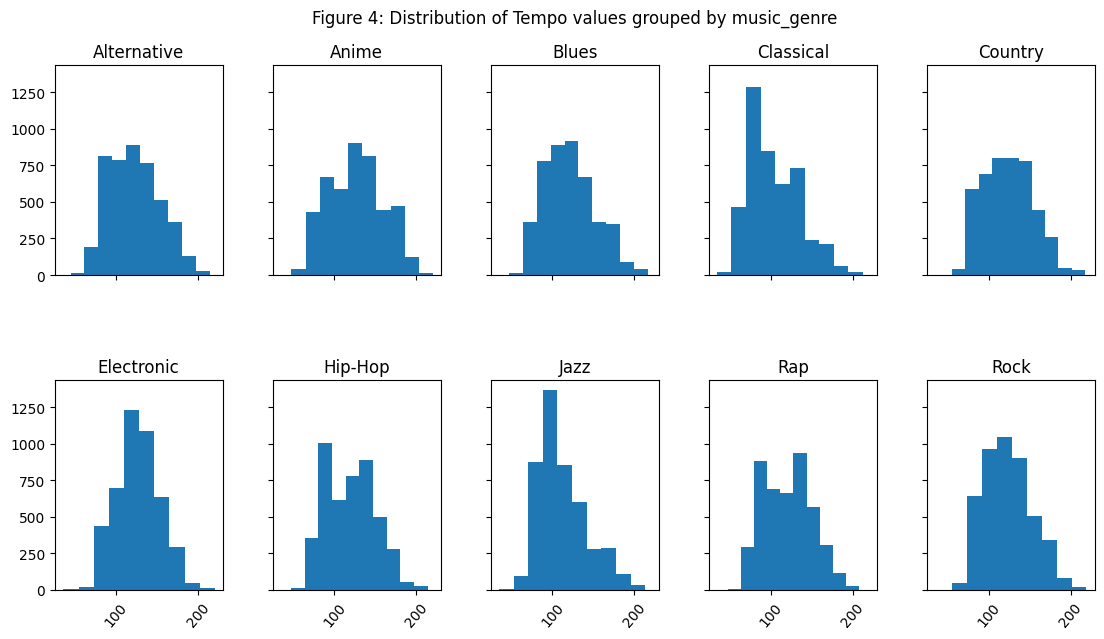

In [ ]:
# the tempo distributions are much more even than they were for song duration, and all roughly follow a Normal distribution.
copied_file['tempo'].hist(by=copied_file['music_genre'], layout = (2,5), sharey=True, sharex = True, xrot = 50, figsize = (13,7))
plt.suptitle("Figure 4: Distribution of Tempo values grouped by music_genre")
plt.show()

In [ ]:
# replace each genre's "?" values with that genre's median duration time (even though distributions are much more similar, median is still better)

# replace "?" with NaN first
file['tempo'] = file['tempo'].map(lambda x: np.nan if x == "?" else x)

# converting column to numeric and rounding
file['tempo'] = pd.to_numeric(file['tempo'])
file['tempo'] = file['tempo'].apply(lambda x: round(x, 4))

# now replace NaN with median tempo, by group
file['tempo'] = file.groupby("music_genre").tempo.transform(lambda x: x.fillna(x.median()))

In [ ]:
# Ok, tempo column has been fixed up

print(file['tempo'].isna().sum())
"?" in file["tempo"].values

0


<ipython-input-25-2194df1a83f3>:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  "?" in file["tempo"].values


False

In [ ]:
# Obtained date

# everything looks good except for "0/4" - let's just drop that single row
print(file["obtained_date"].value_counts())
print()

# drop that row
file = file[file.obtained_date != "0/4"]

# problem solved
print(file["obtained_date"].value_counts())

4-Apr    44748
3-Apr     4067
5-Apr      784
1-Apr      400
0/4          1
Name: obtained_date, dtype: int64

4-Apr    44748
3-Apr     4067
5-Apr      784
1-Apr      400
Name: obtained_date, dtype: int64


#**Data Preprocessing**

In [ ]:
# These encoding steps can be done before doing train-test split, since we are simply encoding
# some values. This is unlike StandardScaler, which needs to be done by using fit_transform on
# the training data, and transform (using fit from only the training data) on the test data,
# so that there are no leaks between train and test data.

# label encode the Mode - we can use label encoder since there are only 2 categories, Major & Minor
le1 = LabelEncoder()
file["mode"] = le1.fit_transform(file["mode"])

<ipython-input-27-c6b6201bb8cd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file["mode"] = le1.fit_transform(file["mode"])


In [ ]:
# the labels of the target variable, music_genre, will need to be label encoded 1-10

le2 = LabelEncoder()
file["music_genre"] = le2.fit_transform(file["music_genre"])

# store a dictionary of the label mappings to be used for the ROC curve plots
mapping = dict(zip(le2.classes_, range(0, len(le2.classes_))))
print(mapping)

mapping_keys = list(mapping.keys())
print(mapping_keys)


# print(le2.inverse_transform(file["music_genre"]))

{'Alternative': 0, 'Anime': 1, 'Blues': 2, 'Classical': 3, 'Country': 4, 'Electronic': 5, 'Hip-Hop': 6, 'Jazz': 7, 'Rap': 8, 'Rock': 9}
['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock']


<ipython-input-28-9c1d0254bf49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file["music_genre"] = le2.fit_transform(file["music_genre"])


In [ ]:
# transform Key into numerical data by using One Hot Encoding, since there are many keys
# and it is not good to have larger numbers/labels for some keys because of differing weights the algorithm will assign

# one-hot encode
key_dummies = pd.get_dummies(file.key)
# concatenate the original file with the 1-hot encoded key column
file = pd.concat([file, key_dummies], axis=1)
# drop the original key column
file.drop(["key"], axis=1, inplace = True)
# also drop one of the 1-hot encoded columns to prevent the key columns from being an overdetermined system of values
file.drop(["G#"], axis=1, inplace = True)

In [ ]:
# Since the date column only has 4 different types of values in it, I want to see if
# it is of any use in the model. There are only 4 unique values, so there shouldn't
# be any time-relation going on - I think it is safe to treat them as categorical
# variables.

# I will use mutual information to measure how dependent these 2 columns are.
# Mutual info can be used both on categorical and continuous data.

# They are almost independent, at 0.024, but maybe the column is still useful to raise AUC by
# a tiny bit. I will 1-hot encode obtained_date
normalized_mutual_info_score(file['music_genre'],
                             file['obtained_date'],
                             average_method='arithmetic')

0.02443785560969185

In [ ]:
# one-hot encode obtained_date
date_dummies = pd.get_dummies(file.obtained_date)
# concatenate the original file with the 1-hot encoded date column
file = pd.concat([file, date_dummies], axis=1)
# drop the original date column
file.drop(["obtained_date"], axis=1, inplace = True)
# also drop one of the 1-hot encoded columns to prevent the date columns from being an overdetermined system of values
file.drop(["5-Apr"], axis=1, inplace = True)

In [ ]:
# drop these columns since I won't be using them for classification
file.drop(["instance_id", "artist_name", "track_name"], axis=1, inplace = True)

In [ ]:
file.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
       'tempo', 'valence', 'music_genre', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#',
       'E', 'F', 'F#', 'G', '1-Apr', '3-Apr', '4-Apr'],
      dtype='object')

#**Split the Dataset**

In [ ]:
# train test split, using 1/10 of each genre for the test set

original_count = file.groupby('music_genre').count()

train, test = train_test_split(file, test_size=0.1, random_state=N_number, stratify=file['music_genre'])
training_count = train.groupby('music_genre').count()

# Make sure that the split went well - use a 1 percent interval bound to verify that the data is evenly split.
# In this case, it is not perfect since some rows were dropped.
num_genres = 10
for i in range(num_genres):
    ratio = training_count.iloc[i][0] / original_count.iloc[i][0]
    print(ratio)
    # assert that all train label classes has 90% of raw data
    assert 0.89 < ratio < 0.91, 'Ratio is not following the rules {}'.format(i)

0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.8999799959991999
0.9


In [ ]:
X_train = train
y_train = X_train["music_genre"]
X_train.drop(["music_genre"], axis = 1, inplace = True)

X_test = test
y_test = X_test["music_genre"]
X_test.drop(["music_genre"], axis = 1, inplace = True)

In [ ]:
# Now scale the data, making sure to only transform the test data using the fit on the training data,
# as well as only scaling the truly numerical columns, unaffecting the one-hot encoded ones.
scaler = StandardScaler()

X_train[['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']] = scaler.fit_transform(X_train[['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']])
X_test[['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']] = scaler.transform(X_test[['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']])

#**Feature Extraction**

In [ ]:
# PCA will likely not work since it simply projects the data onto eigenvectors, maximizing variance. This may make the labelled data less separable in the lower dimensional space.
# LDA is not a great option, since many of the predictors are not Normally Distributed (the one-hot encoded ones).
# I tried t-SNE (typically used only for visualization) and UMAP, of which UMAP seemed to do a slightly better job.

# Configure UMAP hyperparameters
umap = UMAP(n_neighbors=60, n_components=2, n_epochs=1000, min_dist=0.2, local_connectivity=2, random_state=N_number)

# Training on the music training data - use fit_transform method
X_train_umap = umap.fit_transform(X_train, y_train)

# Apply on a test set with only transform method
X_test_umap = umap.transform(X_test)

# Print the shape of new arrays
print('Shape of X_train_res: ', X_train_umap.shape)
print('Shape of X_test_res: ', X_test_umap.shape)

Shape of X_train_res:  (44999, 2)
Shape of X_test_res:  (5000, 2)


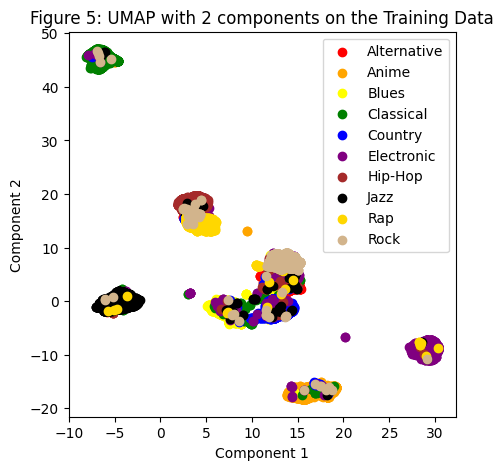

In [ ]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'black', 'gold', 'tan' ]
n_classes = 10

# training set
plt.figure(figsize=(5, 5))
for i, c in zip(range(n_classes), colors):
    plt.scatter(X_train_umap[y_train == i, 0], X_train_umap[y_train == i, 1], c=c, label=mapping_keys[i])
plt.title("Figure 5: UMAP with 2 components on the Training Data")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

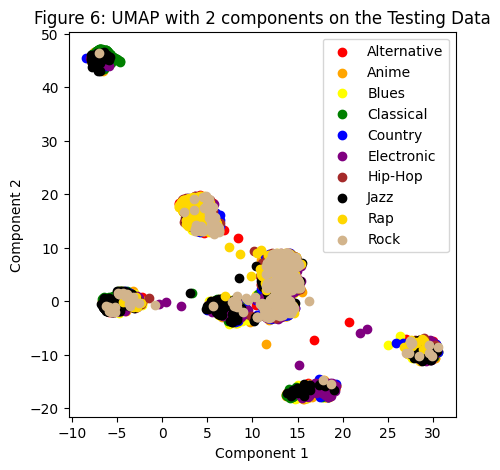

In [ ]:
# testing set
plt.figure(figsize=(5, 5))
for i, c in zip(range(n_classes), colors):
    plt.scatter(X_test_umap[y_test == i, 0], X_test_umap[y_test == i, 1], c=c, label=mapping_keys[i])
plt.title("Figure 6: UMAP with 2 components on the Testing Data")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

#**Train Some Models**

#XGBoost

https://xgboost.readthedocs.io/en/stable/tutorials/model.html

https://stackoverflow.com/questions/52849890/how-to-implement-t-sne-in-a-model

https://towardsdatascience.com/umap-dimensionality-reduction-an-incredibly-robust-machine-learning-algorithm-b5acb01de568

https://towardsdatascience.com/the-similarity-between-t-sne-umap-pca-and-other-mappings-c6453b80f303

https://jlmelville.github.io/uwot/abparams.html

https://github.com/dmlc/xgboost

https://developers.google.com/machine-learning/decision-forests/intro-to-gbdt

In [ ]:
import xgboost
from sklearn.metrics import accuracy_score

gbtree = xgboost.XGBClassifier(n_estimators=200, max_depth=5, seed = N_number)
gbtree.fit(X_train, y_train)

# Make predictions
original_y_pred = gbtree.predict(X_test)

original_y_score = gbtree.predict_proba(X_test)

# Calculate accuracy on the test set
print("Test set accuracy using original dataset: ", accuracy_score(y_test, original_y_pred))

Test set accuracy using original dataset:  0.6414


In [ ]:
gbtree = xgboost.XGBClassifier(n_estimators=200, max_depth=5, seed = N_number)
gbtree.fit(X_train_umap, y_train)

# Make predictions
umap_y_pred = gbtree.predict(X_test_umap)

umap_y_score = gbtree.predict_proba(X_test_umap)

# Calculate accuracy on the test set
print("Test set accuracy using UMAP dimensionally reduced dataset: ", accuracy_score(y_test, umap_y_pred))

Test set accuracy using UMAP dimensionally reduced dataset:  0.4154


#**Plot ROC Curves**

#Original Dataset

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(5000, 10)

In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
original_fpr, original_tpr, original_roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
original_fpr["micro"], original_tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), original_y_score.ravel())
original_roc_auc["micro"] = auc(original_fpr["micro"], original_tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{original_roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.96


In [ ]:
n_classes = 10

for i in range(n_classes):
    original_fpr[i], original_tpr[i], _ = roc_curve(y_onehot_test[:, i], original_y_score[:, i])
    original_roc_auc[i] = auc(original_fpr[i], original_tpr[i])

original_fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
original_mean_tpr = np.zeros_like(original_fpr_grid)

for i in range(n_classes):
    original_mean_tpr += np.interp(original_fpr_grid, original_fpr[i], original_tpr[i])  # linear interpolation

# Average it and compute AUC
original_mean_tpr /= n_classes

original_fpr["macro"] = original_fpr_grid
original_tpr["macro"] = original_mean_tpr
original_roc_auc["macro"] = auc(original_fpr["macro"], original_tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{original_roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


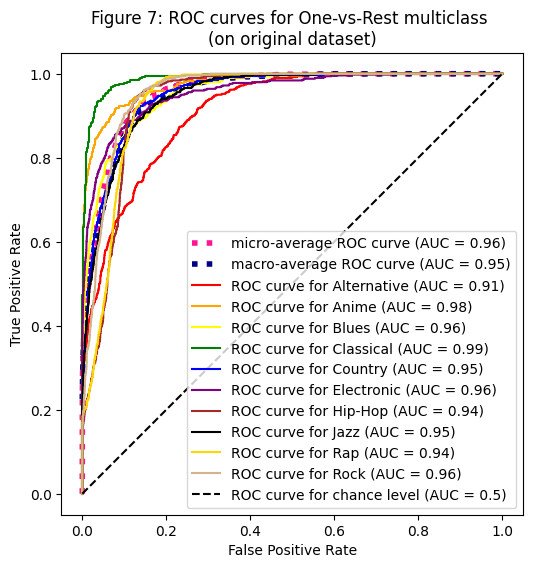

In [ ]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    original_fpr["micro"],
    original_tpr["micro"],
    label=f"micro-average ROC curve (AUC = {original_roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    original_fpr["macro"],
    original_tpr["macro"],
    label=f"macro-average ROC curve (AUC = {original_roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)


colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'black', 'gold', 'tan' ]
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        original_y_score[:, class_id],
        name=f"ROC curve for {mapping_keys[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Figure 7: ROC curves for One-vs-Rest multiclass \n(on original dataset)")
plt.legend()
plt.show()

#UMAP Dimensionally-Reduced Dataset

In [ ]:
# store the fpr, tpr, and roc_auc for all averaging strategies
umap_fpr, umap_tpr, umap_roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
umap_fpr["micro"], umap_tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), umap_y_score.ravel())
umap_roc_auc["micro"] = auc(umap_fpr["micro"], umap_tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{umap_roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.70


In [ ]:
n_classes = 10

for i in range(n_classes):
    umap_fpr[i], umap_tpr[i], _ = roc_curve(y_onehot_test[:, i], umap_y_score[:, i])
    umap_roc_auc[i] = auc(umap_fpr[i], umap_tpr[i])

umap_fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
umap_mean_tpr = np.zeros_like(umap_fpr_grid)

for i in range(n_classes):
    umap_mean_tpr += np.interp(umap_fpr_grid, umap_fpr[i], umap_tpr[i])  # linear interpolation

# Average it and compute AUC
umap_mean_tpr /= n_classes

umap_fpr["macro"] = umap_fpr_grid
umap_tpr["macro"] = umap_mean_tpr
umap_roc_auc["macro"] = auc(umap_fpr["macro"], umap_tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{umap_roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.71


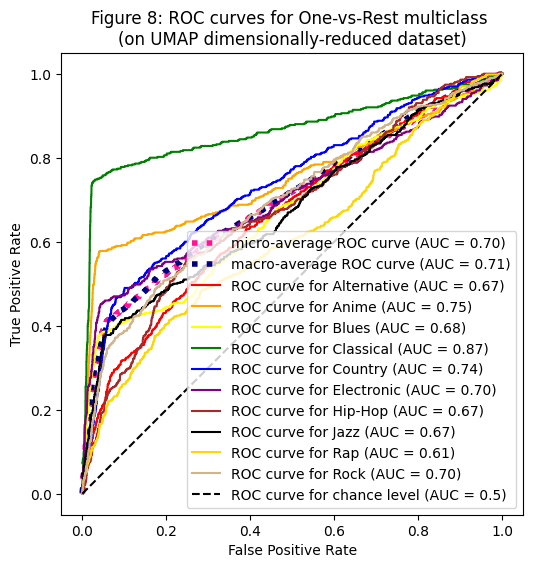

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    umap_fpr["micro"],
    umap_tpr["micro"],
    label=f"micro-average ROC curve (AUC = {umap_roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    umap_fpr["macro"],
    umap_tpr["macro"],
    label=f"macro-average ROC curve (AUC = {umap_roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)


colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'black', 'gold', 'tan' ]
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        umap_y_score[:, class_id],
        name=f"ROC curve for {mapping_keys[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Figure 8: ROC curves for One-vs-Rest multiclass \n(on UMAP dimensionally-reduced dataset)")
plt.legend()
plt.show()